In [28]:
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import StructType,StructField,StringType, IntegerType

In [29]:
spark=SparkSession.builder.enableHiveSupport().getOrCreate()

In [31]:
#create Dataframe
df=spark.read.option('header',True).option('inferSchema',True).csv('Downloads/googleplaystore.csv')
df.show()

+--------------------+--------------+------+-------+----+-----------+----+-----+--------------+--------------------+------------------+------------------+------------+
|                 App|      Category|Rating|Reviews|Size|   Installs|Type|Price|Content Rating|              Genres|      Last Updated|       Current Ver| Android Ver|
+--------------------+--------------+------+-------+----+-----------+----+-----+--------------+--------------------+------------------+------------------+------------+
|Photo Editor & Ca...|ART_AND_DESIGN|   4.1|    159| 19M|    10,000+|Free|    0|      Everyone|        Art & Design|   January 7, 2018|             1.0.0|4.0.3 and up|
| Coloring book moana|ART_AND_DESIGN|   3.9|    967| 14M|   500,000+|Free|    0|      Everyone|Art & Design;Pret...|  January 15, 2018|             2.0.0|4.0.3 and up|
|U Launcher Lite –...|ART_AND_DESIGN|   4.7|  87510|8.7M| 5,000,000+|Free|    0|      Everyone|        Art & Design|    August 1, 2018|             1.2.4|4.0.3 

In [32]:
df.count()

10841

In [33]:
df.describe()

DataFrame[summary: string, App: string, Category: string, Rating: string, Reviews: string, Size: string, Installs: string, Type: string, Price: string, Content Rating: string, Genres: string, Last Updated: string, Current Ver: string, Android Ver: string]

In [34]:
df.printSchema()

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)



In [35]:
#Data Cleaning
#counting null values
from pyspark.sql.functions import when,col,count,isnan,regexp_replace,sum
p=df.select([count(when((isnan(c)) | (col(c).isNull()) | (col(c)=='') | (col(c).contains('NULL')) | (col(c).contains('None')),1)).alias(c) for c in df.columns])
p.show()

+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|App|Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|Genres|Last Updated|Current Ver|Android Ver|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|  0|       0|  1474|      0|   0|       0|   1|    0|             1|     0|           0|          8|          3|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+



In [36]:
#Feature Selection
df=df.drop('Size','Content Rating','Last Updated','Current Ver','Android Ver')

In [37]:
df.show(2)

+--------------------+--------------+------+-------+--------+----+-----+--------------------+
|                 App|      Category|Rating|Reviews|Installs|Type|Price|              Genres|
+--------------------+--------------+------+-------+--------+----+-----+--------------------+
|Photo Editor & Ca...|ART_AND_DESIGN|   4.1|    159| 10,000+|Free|    0|        Art & Design|
| Coloring book moana|ART_AND_DESIGN|   3.9|    967|500,000+|Free|    0|Art & Design;Pret...|
+--------------------+--------------+------+-------+--------+----+-----+--------------------+
only showing top 2 rows



In [38]:
df.printSchema()

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Genres: string (nullable = true)



In [41]:
#Datatype conversion
df=df.withColumn('Installs',regexp_replace(col("Installs"),"[^0-9]",""))\
.withColumn('Installs',col('Installs').cast('Integer'))\
.withColumn('Price',regexp_replace(col("Price"),"[$]",""))\
.withColumn('Price',col('Price').cast('Integer'))\
.withColumn('Reviews',col('Reviews').cast('Integer'))



In [42]:
df.printSchema()

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Reviews: integer (nullable = true)
 |-- Installs: integer (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Genres: string (nullable = true)



In [43]:
df.show(5)

+--------------------+--------------+------+-------+--------+----+-----+--------------------+
|                 App|      Category|Rating|Reviews|Installs|Type|Price|              Genres|
+--------------------+--------------+------+-------+--------+----+-----+--------------------+
|Photo Editor & Ca...|ART_AND_DESIGN|   4.1|    159|   10000|Free|    0|        Art & Design|
| Coloring book moana|ART_AND_DESIGN|   3.9|    967|  500000|Free|    0|Art & Design;Pret...|
|U Launcher Lite –...|ART_AND_DESIGN|   4.7|  87510| 5000000|Free|    0|        Art & Design|
|Sketch - Draw & P...|ART_AND_DESIGN|   4.5| 215644|50000000|Free|    0|        Art & Design|
|Pixel Draw - Numb...|ART_AND_DESIGN|   4.3|    967|  100000|Free|    0|Art & Design;Crea...|
+--------------------+--------------+------+-------+--------+----+-----+--------------------+
only showing top 5 rows



In [44]:
df.createOrReplaceTempView("apps")
x=spark.sql("select * from apps limit 5")
x.show()

+--------------------+--------------+------+-------+--------+----+-----+--------------------+
|                 App|      Category|Rating|Reviews|Installs|Type|Price|              Genres|
+--------------------+--------------+------+-------+--------+----+-----+--------------------+
|Photo Editor & Ca...|ART_AND_DESIGN|   4.1|    159|   10000|Free|    0|        Art & Design|
| Coloring book moana|ART_AND_DESIGN|   3.9|    967|  500000|Free|    0|Art & Design;Pret...|
|U Launcher Lite –...|ART_AND_DESIGN|   4.7|  87510| 5000000|Free|    0|        Art & Design|
|Sketch - Draw & P...|ART_AND_DESIGN|   4.5| 215644|50000000|Free|    0|        Art & Design|
|Pixel Draw - Numb...|ART_AND_DESIGN|   4.3|    967|  100000|Free|    0|Art & Design;Crea...|
+--------------------+--------------+------+-------+--------+----+-----+--------------------+



Find top 10 reviews given to apps

In [79]:
x=spark.sql("select App , sum(Reviews) as total_reviews from apps group by App order by 2 desc limit 10")
x.show()

+--------------------+-------------+
|                 App|total_reviews|
+--------------------+-------------+
|           Instagram|    266241989|
|  WhatsApp Messenger|    207348304|
|      Clash of Clans|    179558781|
|Messenger – Text ...|    169932272|
|      Subway Surfers|    166331958|
|    Candy Crush Saga|    156993136|
|            Facebook|    156286514|
|         8 Ball Pool|     99386198|
|        Clash Royale|     92530298|
|            Snapchat|     68045010|
+--------------------+-------------+



In [81]:

m=df.groupby('App').agg(sum('Reviews').alias("Total_reviews")).orderBy('Total_reviews',ascending=False).limit(10)
m.show()

+--------------------+-------------+
|                 App|Total_reviews|
+--------------------+-------------+
|           Instagram|    266241989|
|  WhatsApp Messenger|    207348304|
|      Clash of Clans|    179558781|
|Messenger – Text ...|    169932272|
|      Subway Surfers|    166331958|
|    Candy Crush Saga|    156993136|
|            Facebook|    156286514|
|         8 Ball Pool|     99386198|
|        Clash Royale|     92530298|
|            Snapchat|     68045010|
+--------------------+-------------+



<Axes: xlabel='App'>

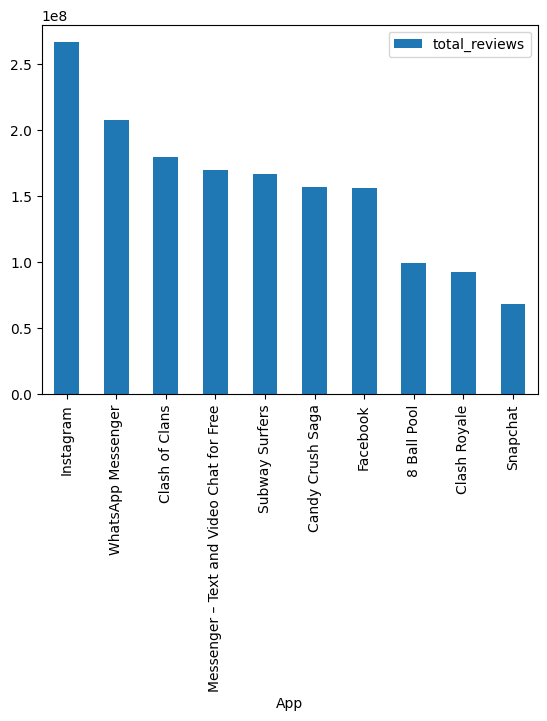

In [111]:
import matplotlib as plt
x.toPandas().plot(x='App',y='total_reviews',kind='bar')

Top 10 install apps with distribution of type (free/paid)

In [112]:
q2=spark.sql("select app,type, sum(installs) as total_installs \
from apps group by app, type  order by 3 desc limit 10")
q2.show()

+------------------+----+--------------+
|               app|type|total_installs|
+------------------+----+--------------+
|    Subway Surfers|Free|    6000000000|
|         Instagram|Free|    4000000000|
|      Google Drive|Free|    4000000000|
|          Hangouts|Free|    4000000000|
|     Google Photos|Free|    4000000000|
|       Google News|Free|    4000000000|
|  Candy Crush Saga|Free|    3500000000|
|WhatsApp Messenger|Free|    3000000000|
|             Gmail|Free|    3000000000|
|      Temple Run 2|Free|    3000000000|
+------------------+----+--------------+



In [85]:
q2=df.groupby('app','type').agg(sum(col('Installs')).alias('total_installs')).orderBy('total_installs',ascending=False)
q2.show()

+--------------------+----+--------------+
|                 app|type|total_installs|
+--------------------+----+--------------+
|      Subway Surfers|Free|    6000000000|
|           Instagram|Free|    4000000000|
|        Google Drive|Free|    4000000000|
|            Hangouts|Free|    4000000000|
|       Google Photos|Free|    4000000000|
|         Google News|Free|    4000000000|
|    Candy Crush Saga|Free|    3500000000|
|  WhatsApp Messenger|Free|    3000000000|
|               Gmail|Free|    3000000000|
|        Temple Run 2|Free|    3000000000|
|Skype - free IM &...|Free|    3000000000|
|Google Chrome: Fa...|Free|    3000000000|
|Messenger – Text ...|Free|    3000000000|
|Maps - Navigate &...|Free|    3000000000|
|     Viber Messenger|Free|    2500000000|
|   Google Play Games|Free|    2000000000|
|            Facebook|Free|    2000000000|
|            Snapchat|Free|    2000000000|
|imo free video ca...|Free|    2000000000|
|  Google Street View|Free|    2000000000|
+----------

<Axes: xlabel='app'>

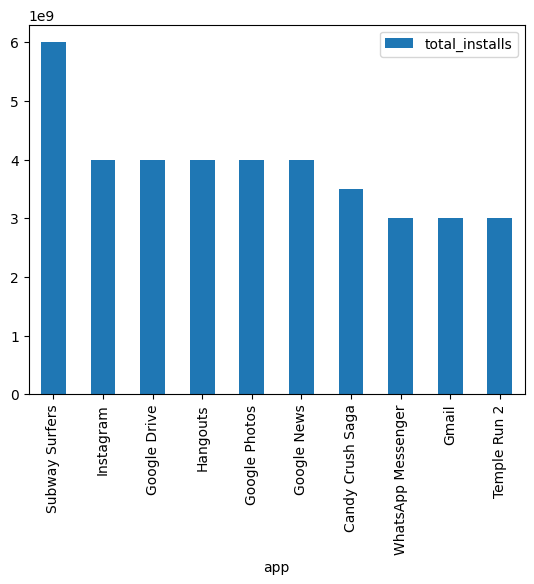

In [116]:
q2.toPandas().plot(x='app',y='total_installs',kind='bar')

Find out category wise distribution of installed apps

In [89]:
q3=spark.sql('select category, sum(installs) as Total_Installs from apps group by category order by 2 desc')
q3.show(50)

+-------------------+--------------+
|           category|Total_Installs|
+-------------------+--------------+
|               GAME|   35086024415|
|      COMMUNICATION|   32647276251|
|       PRODUCTIVITY|   14176091369|
|             SOCIAL|   14069867902|
|              TOOLS|   11452771915|
|             FAMILY|   10258263505|
|        PHOTOGRAPHY|   10088247655|
| NEWS_AND_MAGAZINES|    7496317760|
|   TRAVEL_AND_LOCAL|    6868887146|
|      VIDEO_PLAYERS|    6222002720|
|           SHOPPING|    3247848785|
|      ENTERTAINMENT|    2869160000|
|    PERSONALIZATION|    2325494782|
|BOOKS_AND_REFERENCE|    1921469576|
|             SPORTS|    1751174498|
| HEALTH_AND_FITNESS|    1582072512|
|           BUSINESS|    1001914865|
|            FINANCE|     876648734|
|          EDUCATION|     871452000|
|MAPS_AND_NAVIGATION|     719281890|
|          LIFESTYLE|     537643539|
|            WEATHER|     426100520|
|     FOOD_AND_DRINK|     273898751|
|             DATING|     264310807|
|

In [90]:
d=df.groupby('category').agg(sum('installs').alias('Total_Installs'))\
.orderBy('Total_Installs',ascending=False)
d.show()

+-------------------+--------------+
|           category|Total_Installs|
+-------------------+--------------+
|               GAME|   35086024415|
|      COMMUNICATION|   32647276251|
|       PRODUCTIVITY|   14176091369|
|             SOCIAL|   14069867902|
|              TOOLS|   11452771915|
|             FAMILY|   10258263505|
|        PHOTOGRAPHY|   10088247655|
| NEWS_AND_MAGAZINES|    7496317760|
|   TRAVEL_AND_LOCAL|    6868887146|
|      VIDEO_PLAYERS|    6222002720|
|           SHOPPING|    3247848785|
|      ENTERTAINMENT|    2869160000|
|    PERSONALIZATION|    2325494782|
|BOOKS_AND_REFERENCE|    1921469576|
|             SPORTS|    1751174498|
| HEALTH_AND_FITNESS|    1582072512|
|           BUSINESS|    1001914865|
|            FINANCE|     876648734|
|          EDUCATION|     871452000|
|MAPS_AND_NAVIGATION|     719281890|
+-------------------+--------------+
only showing top 20 rows



<Axes: title={'center': 'Category wise Distribution of Installed Apps'}, xlabel='category'>

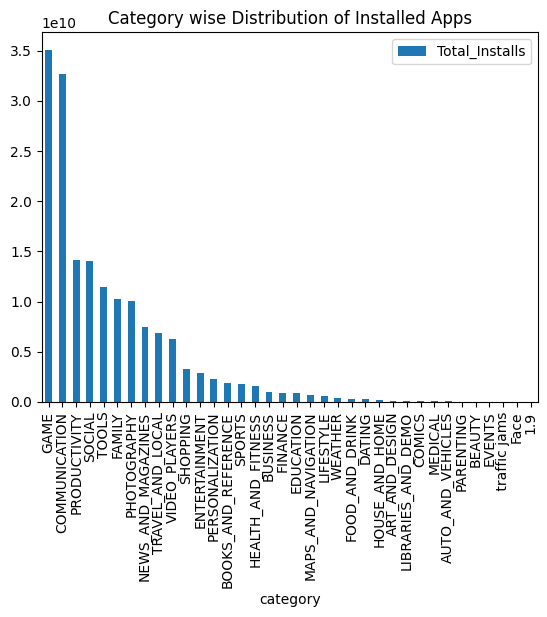

In [120]:
q3.toPandas().plot(x='category',y='Total_Installs',kind='bar',
                   title='Category wise Distribution of Installed Apps')

Top paid apps

In [121]:
q4=spark.sql('select app, sum(installs) as total_installs from apps where type="Paid" group by 1 order by 2 desc limit 5')
q4.show()

+--------------------+--------------+
|                 app|total_installs|
+--------------------+--------------+
|           Minecraft|      20000000|
|       Hitman Sniper|      10000000|
| Facetune - For Free|       3000000|
|Beautiful Widgets...|       2000000|
|          HD Widgets|       2000000|
+--------------------+--------------+



In [93]:
top_app=df.filter(df.Type=='Paid').groupby('app').agg(sum('installs').alias('total_installs'))\
.orderBy('total_installs',ascending=False)
top_app.show()

+--------------------+--------------+
|                 app|total_installs|
+--------------------+--------------+
|           Minecraft|      20000000|
|       Hitman Sniper|      10000000|
| Facetune - For Free|       3000000|
|          HD Widgets|       2000000|
|Beautiful Widgets...|       2000000|
|Infinity Dungeon VIP|       1000000|
|     Toca Life: City|       1000000|
|League of Stickma...|       1000000|
| DraStic DS Emulator|       1000000|
|             Threema|       1000000|
|          True Skate|       1000000|
| Fruit Ninja Classic|       1000000|
|              Tasker|       1000000|
|Five Nights at Fr...|       1000000|
|   Where's My Water?|       1000000|
|   Cut the Rope GOLD|       1000000|
|Stickman Legends:...|       1000000|
|Lost Journey (Dre...|       1000000|
|         Bloons TD 5|       1000000|
|Card Wars - Adven...|       1000000|
+--------------------+--------------+
only showing top 20 rows



<Axes: title={'center': 'Top paid Apps'}, xlabel='app'>

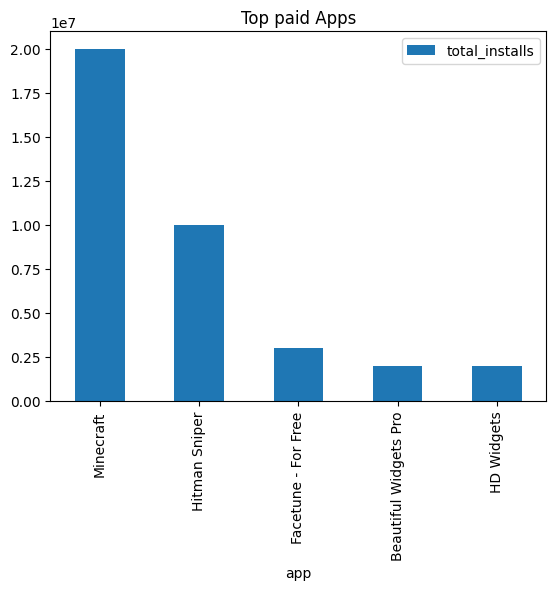

In [124]:
q4.toPandas().plot(x='app',y='total_installs',kind='bar',
                   title='Top paid Apps')

Top rated paid apps

In [126]:
q5=spark.sql('select app,sum(reviews) as top_reviews from apps where type="Paid" group by app order by 2 desc limit 7')
q5.show()

+--------------------+-----------+
|                 app|top_reviews|
+--------------------+-----------+
|           Minecraft|    4751900|
|       Hitman Sniper|     408292|
|Grand Theft Auto:...|     348962|
|Beautiful Widgets...|     195780|
|         Bloons TD 5|     190086|
|   Where's My Water?|     188740|
| Facetune - For Free|     148659|
+--------------------+-----------+



In [78]:
top_reviews=df.filter(df.Type=='Paid').groupby('app').agg(sum('Reviews').alias('top_reviews'))\
.orderBy('top_reviews',ascending=False)
top_reviews.show()

+--------------------+-----------+
|                 app|top_reviews|
+--------------------+-----------+
|           Minecraft|    4751900|
|       Hitman Sniper|     408292|
|Grand Theft Auto:...|     348962|
|Beautiful Widgets...|     195780|
|         Bloons TD 5|     190086|
|   Where's My Water?|     188740|
| Facetune - For Free|     148659|
|Card Wars - Adven...|     129603|
|          True Skate|     129409|
|          HD Widgets|     117231|
|Five Nights at Fr...|     100805|
| DraStic DS Emulator|      87766|
| Fruit Ninja Classic|      85468|
|           Hitman GO|      84114|
|ES File Explorer/...|      81614|
|        Weather Live|      76593|
|Five Nights at Fr...|      73919|
|     Toca Life: City|      62185|
|   Cut the Rope GOLD|      61264|
|ai.type keyboard ...|      57076|
+--------------------+-----------+
only showing top 20 rows



<Axes: title={'center': 'Top rated paid Apps'}, xlabel='app'>

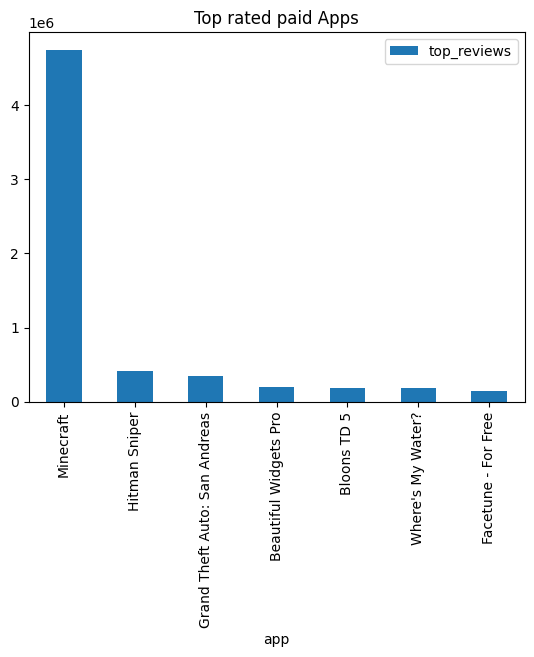

In [131]:
q5.toPandas().plot(x='app',y='top_reviews',kind='bar',
                   title='Top rated paid Apps')